<a href="https://colab.research.google.com/github/BirenderPanwar/tsai_eva4p2/blob/master/4-FaceRecognition/notebooks/S4_FaceRecognition_Attempt1_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition
**Attempt-1:**

Build model to recognize own faces

Custom dataset of 10 Bollywood start face images (25 images per person) are added to LFW-Funneled dataset and then entire dataset is sued to build Face Recognition model. 
IFW Dataset: http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz


In [ ]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch

# check the allocation manhine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
cuda avaiable: True, Device: cuda:0


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session4/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session4/notebooks


In [ ]:
# Import standard packages
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder

In [ ]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.6"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations # --no-cache-dir

0.4.6


In [ ]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [ ]:
import shutil
#shutil.rmtree('./logs_lwf_v1')

In [ ]:
from pathlib import Path

# important folders used in this application

SOLUTION_LOG_DIR = "logs_lwf"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [ ]:
from utils.common_utils import LR_UPDATE_TY

# Application specific configurations
config_params = dict(
    seed=1,
    batch_size=16,
    num_workers=6,
    epochs=100,
    lr_update_ty=LR_UPDATE_TY.EPOCHWISE,
    resume_training = False, 
    load_model_path = Path(f'./logs/saved_models/ep1_testloss_1.322092000.pth'), # used when resume_training is True
    #load_model_path = Path(f'./{SAVED_MODELS_DIR}/ep2_testloss_1.160373000.pth'), # used when resume_training is True
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

In [ ]:
# dataset path where zip files are placed. this contains LFW and own images combined
dataset_zip_file = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session4/lfw_funneled_custom.zip'

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva4p2_s4_dataset'

In [ ]:
import shutil
#shutil.rmtree(root_dataset)

In [ ]:
# ibs-> indian bollywood stars
ibs_class_names = ['Akshay_Kumar', 'Amitabh_Bachchan', 'Amrish_Puri', 'Anil_Kapoor', 'Kajol', 'Katrina_Kaif', 'Madhuri_Dixit', 'Rajesh_Khanna', 'Shilpa_Shetty', 'Vinod_Khanna']
ibs_class_shortname = ['Akshya', 'Amitabh', 'Amrish', 'Anil', 'Kajol', 'Katrina', 'Madhuri', 'Rajesh', 'Shilpa', 'Vinod']

def display_classnames(shortname_list, fullname_list):
  for shortname, fullname in zip(shortname_list, fullname_list):
    print(f'{shortname}: {fullname}') 

## Preparing Dataset

In [ ]:
import utils.data_utils as dutils

In [ ]:
# Extracting zipped dataset into colab internal memory
%%time

if not Path(root_dataset).exists():
    print(f'Extracting dataset images...')
    dutils.extract_dataset(fn=dataset_zip_file, dest=root_dataset)

CPU times: user 69 µs, sys: 0 ns, total: 69 µs
Wall time: 72.7 µs


In [ ]:
# Total num of classes
print(f'Total number of classes: {len(os.listdir(root_dataset))}')

Total number of classes: 5759


In [ ]:
remove_list = []
for classname in os.listdir(root_dataset):
    classdir = os.path.join(root_dataset, classname)
    if(len(os.listdir(classdir)) < 20):
      remove_list.append(classname)  

print(f"Num of class with less than 20 images: {len(remove_list)}")

Num of class with less than 20 images: 5687


In [ ]:
# remove class with less images
for classname in remove_list:
    classdir = os.path.join(root_dataset, classname)
    if Path(classdir).exists():
      shutil.rmtree(classdir)

# Total num of classes
print(f'Final number of classes: {len(os.listdir(root_dataset))}')

Final number of classes: 72


In [ ]:
# check the custom dataset summary added to the original dataset
dutils.get_dataset_count(root_dataset, ibs_class_names)

Akshay_Kumar: 25 images
Amitabh_Bachchan: 25 images
Amrish_Puri: 25 images
Anil_Kapoor: 25 images
Kajol: 25 images
Katrina_Kaif: 25 images
Madhuri_Dixit: 25 images
Rajesh_Khanna: 25 images
Shilpa_Shetty: 25 images
Vinod_Khanna: 25 images

Total images: 250


# Prepare Data Transforms and DataLoader

In [ ]:
from utils.ImageAugmentationUtils import AlbumImageAugmentation
from utils.ImageAugmentationUtils import PyTorchImageAugmentation

means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

imgAugmentation = AlbumImageAugmentation(means, stds, size=224)
#imgAugmentation = PyTorchImageAugmentation(means, stds, size=224)

train_transforms = imgAugmentation.get_train_transform()
test_transforms = imgAugmentation.get_test_transform()

In [ ]:
dataloader_args = dict(shuffle=False, batch_size=config_params["batch_size"], num_workers=config_params["num_workers"], pin_memory=True) if isCuda else dict(shuffle=True, batch_size=8)

train_loader, test_loader = dutils.prepare_dataloader(datadir=root_dataset, 
                                               train_transforms=train_transforms, 
                                               test_transforms=test_transforms, 
                                               dataloader_args=dataloader_args, 
                                               valid_size=0.30)


class_names = train_loader.dataset.classes
num_classes = len(class_names)
print(f'\nNum of classes: {num_classes}\nClasses: {class_names}\n')



Total data: 3273

Training size: 2292
Testing size: 981

Num of classes: 72
Classes: ['Akshay_Kumar', 'Alejandro_Toledo', 'Alvaro_Uribe', 'Amelie_Mauresmo', 'Amitabh_Bachchan', 'Amrish_Puri', 'Andre_Agassi', 'Angelina_Jolie', 'Anil_Kapoor', 'Ariel_Sharon', 'Arnold_Schwarzenegger', 'Atal_Bihari_Vajpayee', 'Bill_Clinton', 'Carlos_Menem', 'Colin_Powell', 'David_Beckham', 'Donald_Rumsfeld', 'George_Robertson', 'George_W_Bush', 'Gerhard_Schroeder', 'Gloria_Macapagal_Arroyo', 'Gray_Davis', 'Guillermo_Coria', 'Hamid_Karzai', 'Hans_Blix', 'Hugo_Chavez', 'Igor_Ivanov', 'Jack_Straw', 'Jacques_Chirac', 'Jean_Chretien', 'Jennifer_Aniston', 'Jennifer_Capriati', 'Jennifer_Lopez', 'Jeremy_Greenstock', 'Jiang_Zemin', 'John_Ashcroft', 'John_Negroponte', 'Jose_Maria_Aznar', 'Juan_Carlos_Ferrero', 'Junichiro_Koizumi', 'Kajol', 'Katrina_Kaif', 'Kofi_Annan', 'Laura_Bush', 'Lindsay_Davenport', 'Lleyton_Hewitt', 'Luiz_Inacio_Lula_da_Silva', 'Madhuri_Dixit', 'Mahmoud_Abbas', 'Megawati_Sukarnoputri', 'Michael_

# Visualize few training images

In [ ]:
from utils.plot_utils import PlotUtils

putils = PlotUtils(device, class_names, means, stds)

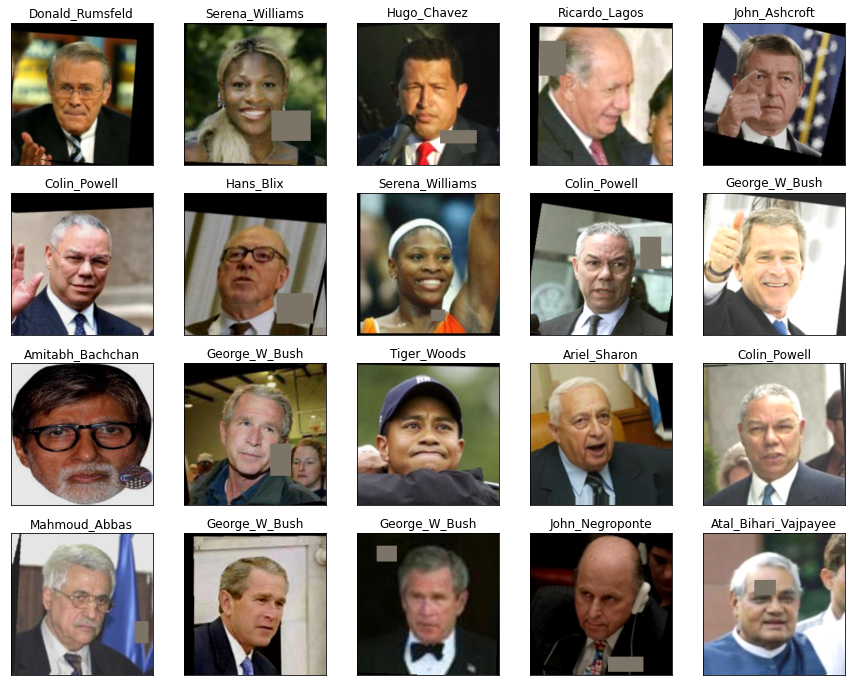

In [ ]:
# visualize how image aumentation is applied on few training dataset images: 
#display_classnames(class_shortname, class_names)
putils.plot_dataset_images(train_loader, figsize=(15,12), save_filename=f'{PLOT_DIR}/dataset_samples.jpg')

In [ ]:
%time
samples = next(iter(train_loader))

# Image dimension
print(f'Image size: {samples[0][0].shape}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Image size: torch.Size([3, 224, 224])


# Pretrained InceptionResnetV1 network

In [ ]:
# load pre-training model
from fr_models.inception_resnet_v1 import InceptionResnetV1
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes=num_classes)

In [ ]:
# view last few layesr to find out layesr we need to chnage and unfreeze
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [ ]:
# Remove the last layers after conv block and place in layer_list .
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [ ]:
# Put all beginning layers in an nn.Sequential . model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

# training just final layers
for param in model_ft.parameters():
    param.requires_grad = False

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [ ]:
# apply the final layers back to the new Sequential model. these layers will be trained
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(512, 512)
#model_ft.softmax = nn.Softmax(dim=1)

In [ ]:
from torchsummary import summary
model_name = "InceptionResnetV1_FaceRec"
model_ft = model_ft.to(device)
#summary(model_ft, input_size=(3,224,224))
#print(model)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FRConvNetwork(nn.Module):
    def __init__(self, loaded_lodel, num_classes=10):
        super(FRConvNetwork, self).__init__()
        self.convlayers = loaded_lodel
        self.fc_final = nn.Linear(512, num_classes)

    def forward(self, x, embed=False):
        x = self.convlayers(x)
        if embed:
            return x
        x = self.fc_final(x)
        x = nn.Softmax(dim=1)(x)
        return x

In [ ]:
from torchsummary import summary
model_name = "InceptionResnetV1_FaceRec"
model = FRConvNetwork(model_ft, num_classes=num_classes).to(device)
summary(model, input_size=(3,224,224))
#print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

## LR Finder

The model is trained for num_iter iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to end_lr. The increase can be linear (step_mode="linear") or exponential (step_mode="exp"); linear provides good results for small ranges while exponential is recommended for larger ranges

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=400, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


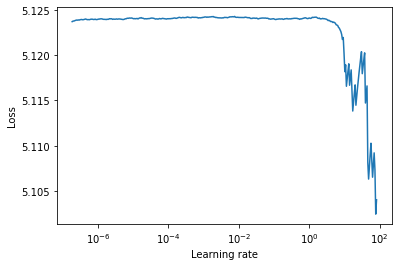

In [ ]:
# Note that the loss in the loss vs. learning rate plot is the training loss.
lr_finder.plot()

In [ ]:
# To restore the model and optimizer to their initial state
lr_finder.reset()

'''
Here model is evaluated on that validation dataset after each iteration.
The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. 
The disadvantage is that it takes significantly longer to run
'''
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=200, step_mode="exp")

In [ ]:
# Note that the loss in the loss vs. learning rate plot is the validation loss.
lr_finder.plot()

## Face Recognition Model

In [ ]:
model_name = "InceptionResnetV1_FaceRec"
model = FRConvNetwork(model_ft,num_classes=num_classes).to(device)

In [ ]:
import numpy as np
import torch.nn.functional as F

# fxn to get embedding vector of size 3.. pls note we have configured vector of size 3 in CNN network
def get_embedding(device, model, loader, num_samples=100):
    model = model.to(device).eval()
    full_embeds = []
    full_labels = []
    with torch.no_grad():
        for i, (data, labels) in enumerate(loader):
            data = data[:num_samples].to(device) #
            full_labels.append(labels[:num_samples].cpu().detach().numpy())
            embeds = model(data, embed=True)
            full_embeds.append(F.normalize(embeds.detach().cpu()).numpy())
    model = model.cpu()
    return np.concatenate(full_embeds), np.concatenate(full_labels)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_embedding(embeds, labels, save_filename=None):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    # Create a sphere
    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='w', alpha=0.3, linewidth=0)
    ax.scatter(embeds[:,0], embeds[:,1], embeds[:,2], c=labels, s=20)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    #ax.set_aspect("equal")
    plt.tight_layout()
    if save_filename:
      fig.savefig(save_filename)

## Build and train model

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau
import torch.nn.functional as F

EPOCHS = config_params['epochs']
max_lr = 0.1   # maximum LR 
min_lr = 0.015  # minimum LR 
L2_val = 1e-4 # L2 Regularization
start_epoch = 1
step_size = 12 # num of epoch, if LR is update epoch wise
if config_params["lr_update_ty"] == LR_UPDATE_TY.BATCHWISE:
  step_size = 2000

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val) 
#optimizer = torch.optim.Adam(model.parameters(), lr=min_lr)

# CyclicLR- use one cycle policy: MAX-LR at epoch=5, Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, step_size_down=step_size, mode='triangular2', last_epoch=-1)
#lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)

# reduce LR when modle get stuck in plateu region
#reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)

In [ ]:
from utils.model_utils import ModelUtils
mutils = ModelUtils(model, 
                    device, 
                    train_loader=train_loader, 
                    test_loader=test_loader, 
                    start_epoch = start_epoch,
                    epochs=EPOCHS,
                    criterion=criterion, 
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    lr_update_ty=config_params['lr_update_ty'],
                    reduceLr_scheduler=None,
                    saved_model_dir=SAVED_MODELS_DIR,
                    tqdm_status=True)

In [ ]:
m_history = mutils.build()

  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 1 TRAIN ==> [Batch=144] train_loss=4.276396 train_acc: 11.91 LR=0.015000000: 100%|██████████| 144/144 [00:19<00:00,  7.29it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 1 TEST  ==> [Batch=62] test_loss=4.276236 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 2 TRAIN ==> [Batch=144] train_loss=4.275885 train_acc: 16.75 LR=0.022083333: 100%|██████████| 144/144 [00:21<00:00,  6.79it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 2 TEST  ==> [Batch=62] test_loss=4.275589 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 14.01it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 3 TRAIN ==> [Batch=144] train_loss=4.274917 train_acc: 16.75 LR=0.029166667: 100%|██████████| 144/144 [00:20<00:00,  7.04it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 3 TEST  ==> [Batch=62] test_loss=4.274193 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 4 TRAIN ==> [Batch=144] train_loss=4.272145 train_acc: 16.75 LR=0.036250000: 100%|██████████| 144/144 [00:19<00:00,  7.25it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 4 TEST  ==> [Batch=62] test_loss=4.268749 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 13.90it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 5 TRAIN ==> [Batch=144] train_loss=4.203820 train_acc: 16.75 LR=0.043333333: 100%|██████████| 144/144 [00:19<00:00,  7.37it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 5 TEST  ==> [Batch=62] test_loss=4.151754 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 6 TRAIN ==> [Batch=144] train_loss=4.128847 train_acc: 16.75 LR=0.050416667: 100%|██████████| 144/144 [00:19<00:00,  7.23it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 6 TEST  ==> [Batch=62] test_loss=4.150668 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 14.04it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 7 TRAIN ==> [Batch=144] train_loss=4.126512 train_acc: 16.75 LR=0.057500000: 100%|██████████| 144/144 [00:20<00:00,  7.11it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 7 TEST  ==> [Batch=62] test_loss=4.145614 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 8 TRAIN ==> [Batch=144] train_loss=4.126333 train_acc: 17.32 LR=0.064583333: 100%|██████████| 144/144 [00:20<00:00,  6.97it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 8 TEST  ==> [Batch=62] test_loss=4.150620 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 14.01it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 9 TRAIN ==> [Batch=144] train_loss=4.127010 train_acc: 17.67 LR=0.071666667: 100%|██████████| 144/144 [00:20<00:00,  7.19it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 9 TEST  ==> [Batch=62] test_loss=4.150850 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 10 TRAIN ==> [Batch=144] train_loss=4.125633 train_acc: 18.54 LR=0.078750000: 100%|██████████| 144/144 [00:19<00:00,  7.29it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 10 TEST  ==> [Batch=62] test_loss=4.150786 test_acc: 14.88: 100%|██████████| 62/62 [00:04<00:00, 14.06it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 11 TRAIN ==> [Batch=144] train_loss=4.120933 train_acc: 19.33 LR=0.085833333: 100%|██████████| 144/144 [00:19<00:00,  7.26it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 11 TEST  ==> [Batch=62] test_loss=4.137143 test_acc: 19.27: 100%|██████████| 62/62 [00:04<00:00, 13.97it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 12 TRAIN ==> [Batch=144] train_loss=4.118301 train_acc: 21.20 LR=0.092916667: 100%|██████████| 144/144 [00:21<00:00,  6.83it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 12 TEST  ==> [Batch=62] test_loss=4.136344 test_acc: 19.06: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 13 TRAIN ==> [Batch=144] train_loss=4.111787 train_acc: 22.03 LR=0.100000000: 100%|██████████| 144/144 [00:19<00:00,  7.50it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 13 TEST  ==> [Batch=62] test_loss=4.108016 test_acc: 22.32: 100%|██████████| 62/62 [00:04<00:00, 14.05it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 14 TRAIN ==> [Batch=144] train_loss=4.071760 train_acc: 23.17 LR=0.092916667: 100%|██████████| 144/144 [00:21<00:00,  6.78it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 14 TEST  ==> [Batch=62] test_loss=4.072015 test_acc: 22.63: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 15 TRAIN ==> [Batch=144] train_loss=4.063220 train_acc: 23.21 LR=0.085833333: 100%|██████████| 144/144 [00:20<00:00,  7.00it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 15 TEST  ==> [Batch=62] test_loss=4.068437 test_acc: 22.73: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 16 TRAIN ==> [Batch=144] train_loss=4.070526 train_acc: 22.38 LR=0.078750000: 100%|██████████| 144/144 [00:21<00:00,  6.72it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 16 TEST  ==> [Batch=62] test_loss=4.064376 test_acc: 22.63: 100%|██████████| 62/62 [00:04<00:00, 14.10it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 17 TRAIN ==> [Batch=144] train_loss=4.055661 train_acc: 23.52 LR=0.071666667: 100%|██████████| 144/144 [00:20<00:00,  7.02it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 17 TEST  ==> [Batch=62] test_loss=4.061862 test_acc: 22.73: 100%|██████████| 62/62 [00:04<00:00, 14.03it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 18 TRAIN ==> [Batch=144] train_loss=4.058413 train_acc: 23.34 LR=0.064583333: 100%|██████████| 144/144 [00:20<00:00,  7.07it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 18 TEST  ==> [Batch=62] test_loss=4.062599 test_acc: 22.63: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 19 TRAIN ==> [Batch=144] train_loss=4.057490 train_acc: 23.30 LR=0.057500000: 100%|██████████| 144/144 [00:20<00:00,  7.01it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 19 TEST  ==> [Batch=62] test_loss=4.061019 test_acc: 23.65: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 20 TRAIN ==> [Batch=144] train_loss=4.059762 train_acc: 23.69 LR=0.050416667: 100%|██████████| 144/144 [00:20<00:00,  6.99it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 20 TEST  ==> [Batch=62] test_loss=4.070242 test_acc: 22.73: 100%|██████████| 62/62 [00:04<00:00, 13.71it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 21 TRAIN ==> [Batch=144] train_loss=4.049439 train_acc: 25.09 LR=0.043333333: 100%|██████████| 144/144 [00:20<00:00,  6.92it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 21 TEST  ==> [Batch=62] test_loss=4.060167 test_acc: 24.57: 100%|██████████| 62/62 [00:04<00:00, 14.10it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 22 TRAIN ==> [Batch=144] train_loss=4.051920 train_acc: 25.35 LR=0.036250000: 100%|██████████| 144/144 [00:21<00:00,  6.77it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 22 TEST  ==> [Batch=62] test_loss=4.059727 test_acc: 25.59: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 23 TRAIN ==> [Batch=144] train_loss=4.049895 train_acc: 25.79 LR=0.029166667: 100%|██████████| 144/144 [00:21<00:00,  6.84it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 23 TEST  ==> [Batch=62] test_loss=4.058391 test_acc: 25.69: 100%|██████████| 62/62 [00:04<00:00, 13.92it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 24 TRAIN ==> [Batch=144] train_loss=4.081150 train_acc: 22.99 LR=0.022083333: 100%|██████████| 144/144 [00:20<00:00,  6.87it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 24 TEST  ==> [Batch=62] test_loss=4.055026 test_acc: 26.20: 100%|██████████| 62/62 [00:04<00:00, 13.98it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 25 TRAIN ==> [Batch=144] train_loss=4.042347 train_acc: 27.18 LR=0.015000000: 100%|██████████| 144/144 [00:20<00:00,  6.97it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 25 TEST  ==> [Batch=62] test_loss=4.045650 test_acc: 26.20: 100%|██████████| 62/62 [00:04<00:00, 13.99it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 26 TRAIN ==> [Batch=144] train_loss=4.033465 train_acc: 27.53 LR=0.018541667: 100%|██████████| 144/144 [00:20<00:00,  6.90it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 26 TEST  ==> [Batch=62] test_loss=4.033210 test_acc: 27.01: 100%|██████████| 62/62 [00:04<00:00, 13.81it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 27 TRAIN ==> [Batch=144] train_loss=4.026111 train_acc: 27.57 LR=0.022083333: 100%|██████████| 144/144 [00:21<00:00,  6.72it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 27 TEST  ==> [Batch=62] test_loss=4.026600 test_acc: 27.12: 100%|██████████| 62/62 [00:04<00:00, 13.82it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 28 TRAIN ==> [Batch=144] train_loss=4.024585 train_acc: 27.44 LR=0.025625000: 100%|██████████| 144/144 [00:21<00:00,  6.66it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 28 TEST  ==> [Batch=62] test_loss=4.027020 test_acc: 27.12: 100%|██████████| 62/62 [00:04<00:00, 13.85it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 29 TRAIN ==> [Batch=144] train_loss=4.022561 train_acc: 27.71 LR=0.029166667: 100%|██████████| 144/144 [00:19<00:00,  7.35it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 29 TEST  ==> [Batch=62] test_loss=4.026320 test_acc: 27.12: 100%|██████████| 62/62 [00:04<00:00, 14.05it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 30 TRAIN ==> [Batch=144] train_loss=4.021253 train_acc: 27.62 LR=0.032708333: 100%|██████████| 144/144 [00:21<00:00,  6.84it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 30 TEST  ==> [Batch=62] test_loss=4.022792 test_acc: 27.12: 100%|██████████| 62/62 [00:04<00:00, 13.84it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 31 TRAIN ==> [Batch=144] train_loss=4.026758 train_acc: 27.18 LR=0.036250000: 100%|██████████| 144/144 [00:20<00:00,  6.99it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 31 TEST  ==> [Batch=62] test_loss=4.029275 test_acc: 27.01: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 32 TRAIN ==> [Batch=144] train_loss=4.018223 train_acc: 28.01 LR=0.039791667: 100%|██████████| 144/144 [00:20<00:00,  6.99it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 32 TEST  ==> [Batch=62] test_loss=4.026581 test_acc: 27.01: 100%|██████████| 62/62 [00:04<00:00, 13.92it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 33 TRAIN ==> [Batch=144] train_loss=4.024615 train_acc: 27.44 LR=0.043333333: 100%|██████████| 144/144 [00:19<00:00,  7.23it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 33 TEST  ==> [Batch=62] test_loss=4.026858 test_acc: 27.01: 100%|██████████| 62/62 [00:04<00:00, 13.91it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 34 TRAIN ==> [Batch=144] train_loss=4.022395 train_acc: 27.36 LR=0.046875000: 100%|██████████| 144/144 [00:20<00:00,  7.15it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 34 TEST  ==> [Batch=62] test_loss=4.023548 test_acc: 27.01: 100%|██████████| 62/62 [00:04<00:00, 14.10it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 35 TRAIN ==> [Batch=144] train_loss=4.018433 train_acc: 27.71 LR=0.050416667: 100%|██████████| 144/144 [00:19<00:00,  7.30it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 35 TEST  ==> [Batch=62] test_loss=4.022966 test_acc: 27.12: 100%|██████████| 62/62 [00:04<00:00, 14.10it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 36 TRAIN ==> [Batch=144] train_loss=4.031090 train_acc: 26.40 LR=0.053958333: 100%|██████████| 144/144 [00:20<00:00,  6.96it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 36 TEST  ==> [Batch=62] test_loss=4.023721 test_acc: 27.12: 100%|██████████| 62/62 [00:04<00:00, 13.98it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 37 TRAIN ==> [Batch=144] train_loss=4.014575 train_acc: 27.92 LR=0.057500000: 100%|██████████| 144/144 [00:21<00:00,  6.84it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 37 TEST  ==> [Batch=62] test_loss=4.019031 test_acc: 27.22: 100%|██████████| 62/62 [00:04<00:00, 14.16it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 38 TRAIN ==> [Batch=144] train_loss=4.017772 train_acc: 27.62 LR=0.053958333: 100%|██████████| 144/144 [00:20<00:00,  6.91it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 38 TEST  ==> [Batch=62] test_loss=4.016138 test_acc: 27.22: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 39 TRAIN ==> [Batch=144] train_loss=4.011868 train_acc: 27.92 LR=0.050416667: 100%|██████████| 144/144 [00:19<00:00,  7.29it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 39 TEST  ==> [Batch=62] test_loss=4.015400 test_acc: 27.42: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 40 TRAIN ==> [Batch=144] train_loss=4.016762 train_acc: 27.97 LR=0.046875000: 100%|██████████| 144/144 [00:21<00:00,  6.74it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 40 TEST  ==> [Batch=62] test_loss=4.015757 test_acc: 28.24: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 41 TRAIN ==> [Batch=144] train_loss=4.004884 train_acc: 29.76 LR=0.043333333: 100%|██████████| 144/144 [00:20<00:00,  6.96it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 41 TEST  ==> [Batch=62] test_loss=3.998875 test_acc: 30.78: 100%|██████████| 62/62 [00:04<00:00, 14.13it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 42 TRAIN ==> [Batch=144] train_loss=4.000249 train_acc: 29.89 LR=0.039791667: 100%|██████████| 144/144 [00:21<00:00,  6.73it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 42 TEST  ==> [Batch=62] test_loss=3.992411 test_acc: 30.68: 100%|██████████| 62/62 [00:04<00:00, 13.95it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 43 TRAIN ==> [Batch=144] train_loss=3.997026 train_acc: 30.24 LR=0.036250000: 100%|██████████| 144/144 [00:19<00:00,  7.31it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 43 TEST  ==> [Batch=62] test_loss=3.994577 test_acc: 30.68: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 44 TRAIN ==> [Batch=144] train_loss=3.997716 train_acc: 30.19 LR=0.032708333: 100%|██████████| 144/144 [00:19<00:00,  7.35it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 44 TEST  ==> [Batch=62] test_loss=3.990464 test_acc: 30.99: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 45 TRAIN ==> [Batch=144] train_loss=4.005148 train_acc: 29.28 LR=0.029166667: 100%|██████████| 144/144 [00:20<00:00,  6.94it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 45 TEST  ==> [Batch=62] test_loss=3.993771 test_acc: 30.89: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 46 TRAIN ==> [Batch=144] train_loss=3.993477 train_acc: 30.15 LR=0.025625000: 100%|██████████| 144/144 [00:20<00:00,  6.93it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 46 TEST  ==> [Batch=62] test_loss=3.990305 test_acc: 30.99: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 47 TRAIN ==> [Batch=144] train_loss=3.997826 train_acc: 30.10 LR=0.022083333: 100%|██████████| 144/144 [00:20<00:00,  7.02it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 47 TEST  ==> [Batch=62] test_loss=3.989356 test_acc: 30.58: 100%|██████████| 62/62 [00:04<00:00, 14.04it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 48 TRAIN ==> [Batch=144] train_loss=3.995105 train_acc: 30.10 LR=0.018541667: 100%|██████████| 144/144 [00:19<00:00,  7.37it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 48 TEST  ==> [Batch=62] test_loss=3.981136 test_acc: 30.99: 100%|██████████| 62/62 [00:04<00:00, 14.01it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 49 TRAIN ==> [Batch=144] train_loss=3.989026 train_acc: 30.67 LR=0.015000000: 100%|██████████| 144/144 [00:20<00:00,  6.90it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 49 TEST  ==> [Batch=62] test_loss=3.983409 test_acc: 30.99: 100%|██████████| 62/62 [00:04<00:00, 13.89it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 50 TRAIN ==> [Batch=144] train_loss=3.988617 train_acc: 30.54 LR=0.016770833: 100%|██████████| 144/144 [00:20<00:00,  6.91it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 50 TEST  ==> [Batch=62] test_loss=3.984360 test_acc: 31.09: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 51 TRAIN ==> [Batch=144] train_loss=4.002891 train_acc: 29.45 LR=0.018541667: 100%|██████████| 144/144 [00:20<00:00,  6.90it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 51 TEST  ==> [Batch=62] test_loss=3.985771 test_acc: 31.09: 100%|██████████| 62/62 [00:04<00:00, 13.87it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 52 TRAIN ==> [Batch=144] train_loss=3.987660 train_acc: 30.67 LR=0.020312500: 100%|██████████| 144/144 [00:21<00:00,  6.82it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 52 TEST  ==> [Batch=62] test_loss=3.985856 test_acc: 30.99: 100%|██████████| 62/62 [00:04<00:00, 13.78it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 53 TRAIN ==> [Batch=144] train_loss=3.988404 train_acc: 30.72 LR=0.022083333: 100%|██████████| 144/144 [00:19<00:00,  7.49it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 53 TEST  ==> [Batch=62] test_loss=3.988779 test_acc: 30.89: 100%|██████████| 62/62 [00:04<00:00, 14.14it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 54 TRAIN ==> [Batch=144] train_loss=3.987988 train_acc: 30.76 LR=0.023854167: 100%|██████████| 144/144 [00:20<00:00,  7.07it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 54 TEST  ==> [Batch=62] test_loss=3.984369 test_acc: 31.09: 100%|██████████| 62/62 [00:04<00:00, 14.02it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 55 TRAIN ==> [Batch=144] train_loss=3.987358 train_acc: 31.06 LR=0.025625000: 100%|██████████| 144/144 [00:20<00:00,  6.93it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 55 TEST  ==> [Batch=62] test_loss=3.986524 test_acc: 31.29: 100%|██████████| 62/62 [00:04<00:00, 13.94it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 56 TRAIN ==> [Batch=144] train_loss=3.990625 train_acc: 30.98 LR=0.027395833: 100%|██████████| 144/144 [00:19<00:00,  7.25it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 56 TEST  ==> [Batch=62] test_loss=3.981080 test_acc: 31.40: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 57 TRAIN ==> [Batch=144] train_loss=3.985694 train_acc: 30.98 LR=0.029166667: 100%|██████████| 144/144 [00:19<00:00,  7.20it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 57 TEST  ==> [Batch=62] test_loss=3.979917 test_acc: 31.19: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 58 TRAIN ==> [Batch=144] train_loss=3.986496 train_acc: 31.37 LR=0.030937500: 100%|██████████| 144/144 [00:21<00:00,  6.86it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 58 TEST  ==> [Batch=62] test_loss=3.979145 test_acc: 30.99: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 59 TRAIN ==> [Batch=144] train_loss=3.987440 train_acc: 32.02 LR=0.032708333: 100%|██████████| 144/144 [00:21<00:00,  6.65it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 59 TEST  ==> [Batch=62] test_loss=3.978001 test_acc: 31.80: 100%|██████████| 62/62 [00:04<00:00, 14.20it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 60 TRAIN ==> [Batch=144] train_loss=3.981043 train_acc: 32.64 LR=0.034479167: 100%|██████████| 144/144 [00:19<00:00,  7.39it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 60 TEST  ==> [Batch=62] test_loss=3.981444 test_acc: 31.09: 100%|██████████| 62/62 [00:04<00:00, 14.53it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 61 TRAIN ==> [Batch=144] train_loss=3.982775 train_acc: 32.77 LR=0.036250000: 100%|██████████| 144/144 [00:18<00:00,  7.67it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 61 TEST  ==> [Batch=62] test_loss=3.967909 test_acc: 33.23: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 62 TRAIN ==> [Batch=144] train_loss=3.970070 train_acc: 33.60 LR=0.034479167: 100%|██████████| 144/144 [00:21<00:00,  6.80it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 62 TEST  ==> [Batch=62] test_loss=3.962381 test_acc: 33.74: 100%|██████████| 62/62 [00:04<00:00, 13.76it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 63 TRAIN ==> [Batch=144] train_loss=3.955635 train_acc: 35.21 LR=0.032708333: 100%|██████████| 144/144 [00:21<00:00,  6.71it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 63 TEST  ==> [Batch=62] test_loss=3.950696 test_acc: 35.07: 100%|██████████| 62/62 [00:04<00:00, 13.86it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 64 TRAIN ==> [Batch=144] train_loss=3.957946 train_acc: 34.95 LR=0.030937500: 100%|██████████| 144/144 [00:21<00:00,  6.59it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 64 TEST  ==> [Batch=62] test_loss=3.951616 test_acc: 34.96: 100%|██████████| 62/62 [00:04<00:00, 13.42it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 65 TRAIN ==> [Batch=144] train_loss=3.946853 train_acc: 35.82 LR=0.029166667: 100%|██████████| 144/144 [00:19<00:00,  7.27it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 65 TEST  ==> [Batch=62] test_loss=3.940099 test_acc: 35.88: 100%|██████████| 62/62 [00:04<00:00, 14.16it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 66 TRAIN ==> [Batch=144] train_loss=3.945834 train_acc: 36.04 LR=0.027395833: 100%|██████████| 144/144 [00:21<00:00,  6.80it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 66 TEST  ==> [Batch=62] test_loss=3.945275 test_acc: 36.09: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 67 TRAIN ==> [Batch=144] train_loss=3.946202 train_acc: 35.99 LR=0.025625000: 100%|██████████| 144/144 [00:20<00:00,  7.04it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 67 TEST  ==> [Batch=62] test_loss=3.940030 test_acc: 36.09: 100%|██████████| 62/62 [00:04<00:00, 14.14it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 68 TRAIN ==> [Batch=144] train_loss=3.937742 train_acc: 36.82 LR=0.023854167: 100%|██████████| 144/144 [00:20<00:00,  6.93it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 68 TEST  ==> [Batch=62] test_loss=3.938957 test_acc: 35.98: 100%|██████████| 62/62 [00:04<00:00, 14.18it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 69 TRAIN ==> [Batch=144] train_loss=3.929031 train_acc: 36.91 LR=0.022083333: 100%|██████████| 144/144 [00:20<00:00,  7.04it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 69 TEST  ==> [Batch=62] test_loss=3.938338 test_acc: 36.19: 100%|██████████| 62/62 [00:04<00:00, 14.04it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 70 TRAIN ==> [Batch=144] train_loss=3.933763 train_acc: 36.91 LR=0.020312500: 100%|██████████| 144/144 [00:21<00:00,  6.74it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 70 TEST  ==> [Batch=62] test_loss=3.940687 test_acc: 36.19: 100%|██████████| 62/62 [00:04<00:00, 14.11it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 71 TRAIN ==> [Batch=144] train_loss=3.931844 train_acc: 36.87 LR=0.018541667: 100%|██████████| 144/144 [00:20<00:00,  7.09it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 71 TEST  ==> [Batch=62] test_loss=3.938446 test_acc: 36.19: 100%|██████████| 62/62 [00:04<00:00, 14.12it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 72 TRAIN ==> [Batch=144] train_loss=3.927295 train_acc: 37.22 LR=0.016770833: 100%|██████████| 144/144 [00:20<00:00,  7.14it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 72 TEST  ==> [Batch=62] test_loss=3.941063 test_acc: 36.09: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 73 TRAIN ==> [Batch=144] train_loss=3.930642 train_acc: 37.43 LR=0.015000000: 100%|██████████| 144/144 [00:20<00:00,  7.14it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 73 TEST  ==> [Batch=62] test_loss=3.930180 test_acc: 37.10: 100%|██████████| 62/62 [00:04<00:00, 14.01it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 74 TRAIN ==> [Batch=144] train_loss=3.922089 train_acc: 38.53 LR=0.015885417: 100%|██████████| 144/144 [00:19<00:00,  7.20it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 74 TEST  ==> [Batch=62] test_loss=3.933006 test_acc: 36.90: 100%|██████████| 62/62 [00:04<00:00, 13.93it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 75 TRAIN ==> [Batch=144] train_loss=3.919351 train_acc: 38.39 LR=0.016770833: 100%|██████████| 144/144 [00:20<00:00,  7.14it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 75 TEST  ==> [Batch=62] test_loss=3.932223 test_acc: 37.21: 100%|██████████| 62/62 [00:04<00:00, 14.27it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 76 TRAIN ==> [Batch=144] train_loss=3.917271 train_acc: 38.96 LR=0.017656250: 100%|██████████| 144/144 [00:22<00:00,  6.46it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 76 TEST  ==> [Batch=62] test_loss=3.928277 test_acc: 37.10: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 77 TRAIN ==> [Batch=144] train_loss=3.917696 train_acc: 38.87 LR=0.018541667: 100%|██████████| 144/144 [00:21<00:00,  6.77it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 77 TEST  ==> [Batch=62] test_loss=3.936913 test_acc: 36.70: 100%|██████████| 62/62 [00:04<00:00, 13.64it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 78 TRAIN ==> [Batch=144] train_loss=3.915467 train_acc: 38.92 LR=0.019427083: 100%|██████████| 144/144 [00:20<00:00,  7.05it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 78 TEST  ==> [Batch=62] test_loss=3.929002 test_acc: 37.41: 100%|██████████| 62/62 [00:04<00:00, 13.98it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 79 TRAIN ==> [Batch=144] train_loss=3.916605 train_acc: 38.79 LR=0.020312500: 100%|██████████| 144/144 [00:19<00:00,  7.32it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 79 TEST  ==> [Batch=62] test_loss=3.929109 test_acc: 37.41: 100%|██████████| 62/62 [00:04<00:00, 14.36it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 80 TRAIN ==> [Batch=144] train_loss=3.924783 train_acc: 38.05 LR=0.021197917: 100%|██████████| 144/144 [00:20<00:00,  7.12it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 80 TEST  ==> [Batch=62] test_loss=3.925693 test_acc: 37.72: 100%|██████████| 62/62 [00:04<00:00, 14.00it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 81 TRAIN ==> [Batch=144] train_loss=3.915779 train_acc: 38.70 LR=0.022083333: 100%|██████████| 144/144 [00:20<00:00,  6.97it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 81 TEST  ==> [Batch=62] test_loss=3.926867 test_acc: 37.92: 100%|██████████| 62/62 [00:04<00:00, 14.11it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 82 TRAIN ==> [Batch=144] train_loss=3.913372 train_acc: 39.01 LR=0.022968750: 100%|██████████| 144/144 [00:20<00:00,  7.19it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 82 TEST  ==> [Batch=62] test_loss=3.924380 test_acc: 37.51: 100%|██████████| 62/62 [00:04<00:00, 14.21it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 83 TRAIN ==> [Batch=144] train_loss=3.920748 train_acc: 38.35 LR=0.023854167: 100%|██████████| 144/144 [00:19<00:00,  7.23it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 83 TEST  ==> [Batch=62] test_loss=3.930632 test_acc: 37.31: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 84 TRAIN ==> [Batch=144] train_loss=3.910869 train_acc: 38.96 LR=0.024739583: 100%|██████████| 144/144 [00:19<00:00,  7.23it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 84 TEST  ==> [Batch=62] test_loss=3.931467 test_acc: 37.00: 100%|██████████| 62/62 [00:04<00:00, 14.05it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 85 TRAIN ==> [Batch=144] train_loss=3.912610 train_acc: 39.01 LR=0.025625000: 100%|██████████| 144/144 [00:19<00:00,  7.31it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 85 TEST  ==> [Batch=62] test_loss=3.934553 test_acc: 37.10: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 86 TRAIN ==> [Batch=144] train_loss=3.912601 train_acc: 39.09 LR=0.024739583: 100%|██████████| 144/144 [00:20<00:00,  7.15it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 86 TEST  ==> [Batch=62] test_loss=3.930763 test_acc: 37.41: 100%|██████████| 62/62 [00:04<00:00, 13.96it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 87 TRAIN ==> [Batch=144] train_loss=3.916814 train_acc: 38.61 LR=0.023854167: 100%|██████████| 144/144 [00:20<00:00,  7.03it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 87 TEST  ==> [Batch=62] test_loss=3.926679 test_acc: 37.41: 100%|██████████| 62/62 [00:04<00:00, 14.09it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 88 TRAIN ==> [Batch=144] train_loss=3.912404 train_acc: 38.74 LR=0.022968750: 100%|██████████| 144/144 [00:20<00:00,  7.09it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 88 TEST  ==> [Batch=62] test_loss=3.922040 test_acc: 37.92: 100%|██████████| 62/62 [00:04<00:00, 13.40it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 89 TRAIN ==> [Batch=144] train_loss=3.915824 train_acc: 38.39 LR=0.022083333: 100%|██████████| 144/144 [00:20<00:00,  6.89it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 89 TEST  ==> [Batch=62] test_loss=3.924360 test_acc: 37.92: 100%|██████████| 62/62 [00:04<00:00, 13.89it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 90 TRAIN ==> [Batch=144] train_loss=3.913474 train_acc: 38.79 LR=0.021197917: 100%|██████████| 144/144 [00:21<00:00,  6.80it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 90 TEST  ==> [Batch=62] test_loss=3.919991 test_acc: 38.02: 100%|██████████| 62/62 [00:04<00:00, 14.07it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 91 TRAIN ==> [Batch=144] train_loss=3.911977 train_acc: 39.01 LR=0.020312500: 100%|██████████| 144/144 [00:20<00:00,  7.01it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 91 TEST  ==> [Batch=62] test_loss=3.933780 test_acc: 36.80: 100%|██████████| 62/62 [00:04<00:00, 14.19it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 92 TRAIN ==> [Batch=144] train_loss=3.908084 train_acc: 39.14 LR=0.019427083: 100%|██████████| 144/144 [00:19<00:00,  7.57it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 92 TEST  ==> [Batch=62] test_loss=3.924102 test_acc: 37.31: 100%|██████████| 62/62 [00:04<00:00, 14.15it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 93 TRAIN ==> [Batch=144] train_loss=3.908351 train_acc: 39.31 LR=0.018541667: 100%|██████████| 144/144 [00:20<00:00,  7.18it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 93 TEST  ==> [Batch=62] test_loss=3.918903 test_acc: 37.92: 100%|██████████| 62/62 [00:04<00:00, 13.83it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 94 TRAIN ==> [Batch=144] train_loss=3.910571 train_acc: 38.96 LR=0.017656250: 100%|██████████| 144/144 [00:19<00:00,  7.38it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 94 TEST  ==> [Batch=62] test_loss=3.923468 test_acc: 37.31: 100%|██████████| 62/62 [00:04<00:00, 14.34it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 95 TRAIN ==> [Batch=144] train_loss=3.911632 train_acc: 39.14 LR=0.016770833: 100%|██████████| 144/144 [00:20<00:00,  7.02it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 95 TEST  ==> [Batch=62] test_loss=3.918117 test_acc: 37.92: 100%|██████████| 62/62 [00:04<00:00, 14.49it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 96 TRAIN ==> [Batch=144] train_loss=3.909781 train_acc: 38.96 LR=0.015885417: 100%|██████████| 144/144 [00:19<00:00,  7.42it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 96 TEST  ==> [Batch=62] test_loss=3.935499 test_acc: 36.70: 100%|██████████| 62/62 [00:04<00:00, 14.44it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 97 TRAIN ==> [Batch=144] train_loss=3.907804 train_acc: 39.35 LR=0.015000000: 100%|██████████| 144/144 [00:18<00:00,  7.73it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 97 TEST  ==> [Batch=62] test_loss=3.933106 test_acc: 36.49: 100%|██████████| 62/62 [00:04<00:00, 14.76it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 98 TRAIN ==> [Batch=144] train_loss=3.909313 train_acc: 39.40 LR=0.015442708: 100%|██████████| 144/144 [00:19<00:00,  7.54it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 98 TEST  ==> [Batch=62] test_loss=3.916690 test_acc: 37.82: 100%|██████████| 62/62 [00:04<00:00, 14.57it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 99 TRAIN ==> [Batch=144] train_loss=3.912635 train_acc: 39.01 LR=0.015885417: 100%|██████████| 144/144 [00:19<00:00,  7.35it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 99 TEST  ==> [Batch=62] test_loss=3.943863 test_acc: 35.68: 100%|██████████| 62/62 [00:04<00:00, 14.62it/s]
  0%|          | 0/144 [00:00<?, ?it/s]

Epoch: 100 TRAIN ==> [Batch=144] train_loss=3.907581 train_acc: 39.44 LR=0.016328125: 100%|██████████| 144/144 [00:19<00:00,  7.51it/s]
  0%|          | 0/62 [00:00<?, ?it/s]
Epoch: 100 TEST  ==> [Batch=62] test_loss=3.926186 test_acc: 37.92: 100%|██████████| 62/62 [00:04<00:00, 14.83it/s]


In [ ]:
#embeds, labels = get_embedding(device, model, train_loader)
#plot_embedding(embeds, labels, save_filename=f'{SAVED_RESULTS_DIR}/embedding.jpg')

In [ ]:
m_history.result_summary()

Training best result: Accuracy: 39.44 at Epoch 100
Testing  best result: Accuracy: 38.02 at Epoch 90
Acuracy Gap: 1.42


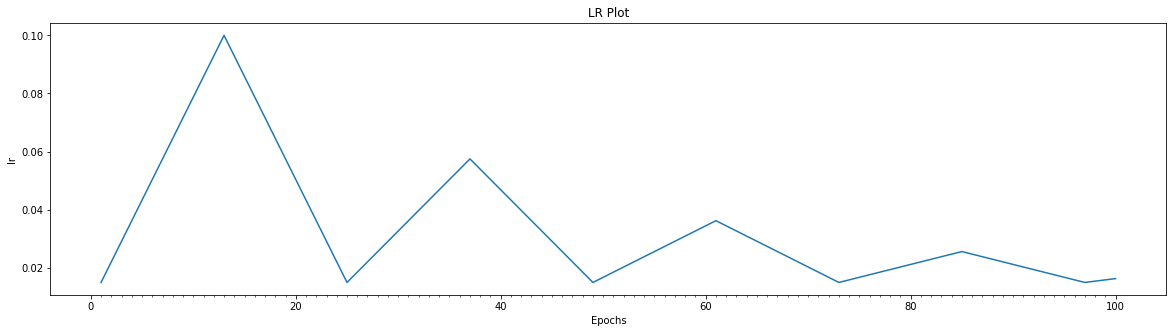

In [ ]:
m_history.plot_data_against_epoch(title="LR Plot", seriesname="lr", save_filename=f'{SAVED_RESULTS_DIR}/lr_plot.jpg')

In [ ]:
best_model = torch.load(f'{SAVED_MODELS_DIR}/bestmodel.pt')

In [ ]:
import utils.model_utils as mutils_fxn
testacc, testsize = mutils_fxn.get_test_accuracy(best_model, device, test_loader)
print(f'Accuracy of the model on the {testsize} test images: {testacc:0.2f}%')

Accuracy of the model on the 981 test images: 38.02%


In [ ]:
# Class based accuracy
#mutils_fxn.get_class_based_accuracy(best_model, device, test_loader, class_names)

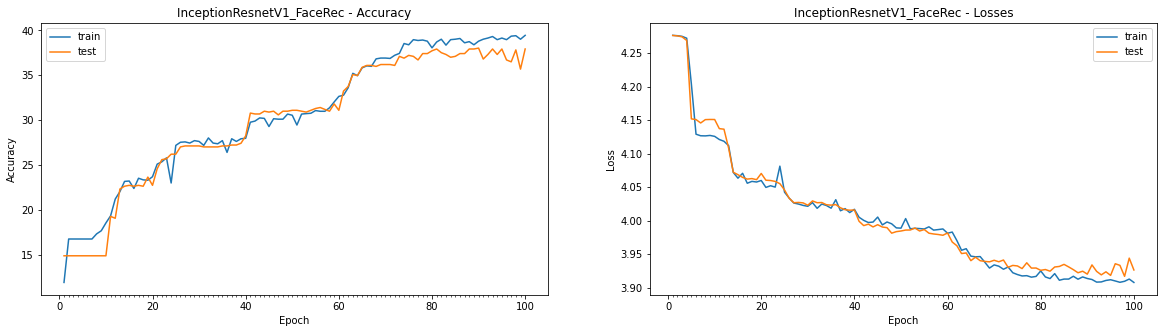

In [ ]:
# Accurracy and loss history plot
m_history.plot_history(title=model_name, save_filename=f'{PLOT_DIR}/model_history.jpg')